In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
from astropy.io import fits
import scipy
sys.path.append('../../wdtools/')
import wdtools
sys.path.append('../../')
import WD_models
from bisect import bisect_left
import lmfit
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458


na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52

ca2k = 3934.777

ch = 4302

plt.rcParams.update({'font.size': 18})
#%matplotlib inline
from matplotlib.colors import LogNorm

Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
lamgrid = np.arange(3500, 9000)
sigma = 1.5 # Angstrom
convolve = True

In [3]:
sp = wdtools.SpecTools()

def get_spectrum(source_id):
    path = '../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

def rv_corr(wl, fl):
    obs_alpha,_,_, _, _ = sp.find_centroid(wl, fl, halpha, make_plot = False, n_fit = 2, 
                            half_window = 50, debug = False, window_step = 5)

    vr = - 1e-3 * speed_light * (obs_alpha - halpha)/halpha

    fl, shift_wl = pyasl.dopplerShift(wl, fl, vr, edgeHandling = 'fillValue', fillValue = 1)
    return wl, fl

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def logg_to_radius(logg):
    g = 10**logg * 0.01 # to SI
    
    R = radius_sun * 10 ** ( - ((np.log10(g / g_sun) + 0.02) / 0.67))
    return R

interpsda = pickle.load(open('interp/interpsda.p', 'rb'))

def get_sda(teff, logg, alpha = 0):
    wl, fl = lamgrid, 10**interpsda((logg, teff, np.log10(lamgrid)))
    
    if convolve:
        fl = scipy.ndimage.gaussian_filter(fl, sigma)
    return wl, fl

def plot_metals(wl, fl, source = '', teff = 6000, logg = 4.5, alpha = 0):
    
    modelwl, modelfl = get_sda(teff, logg, alpha = alpha)
    
    f = plt.figure(figsize = (10, 15))
    gs = f.add_gridspec(4, 2)
    
    ax1 = f.add_subplot(gs[0, :])
    
    
    idx = bisect_left(wl, 5865)
    plt.plot(wl, fl / fl[idx])
    #plt.title(str(obj['source_id'][0]) + ' (%i, %.1f)'%(teff, logg))
    
    ax2 = f.add_subplot(gs[1, 0])
    
    cwl, cfl = cont_norm(wl, fl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2k, 20, 5)
    plt.plot(cwl, cfl)
    #plt.xlim(3925, 3940)
    plt.axvline(ca2k, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.title('Ca II K')
    plt.ylim(0.5, 1.3)
    
    
    ax3 = f.add_subplot(gs[1,1])

    
    cwl, cfl = cont_norm(wl, fl, na2, 75, 15)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, na2, 75, 15)
    plt.plot(cwl, cfl)
#     plt.axvline(na1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(na2, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Na')
    
    ax4 = f.add_subplot(gs[2,0])
    
    cwl, cfl = cont_norm(wl, fl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ca2, 400, 25)
    plt.plot(cwl, cfl)
    plt.xlim(ca1-25, ca3+25)
#     plt.axvline(ca1, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca2, linestyle = '-', color = 'k', linewidth = 0.5)
#     plt.axvline(ca3, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.5, 1.3)
    plt.title('Ca Triplet')
    
    ax5 = f.add_subplot(gs[2,1])
    
    cwl, cfl = cont_norm(wl, fl, ch, 26, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, ch, 26, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('CH G-Band')
    
    ax6 = f.add_subplot(gs[3,0])
    
    cwl, cfl = cont_norm(wl, fl, 4320, 30, 5)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, 4320, 30, 5)
    plt.plot(cwl, cfl)
   # plt.xlim(ca1-20, ca3+20)
    plt.ylim(0.5, 1.3)
    plt.title('Carbon')
    
    ax6 = f.add_subplot(gs[3,1])
    
    cwl, cfl = cont_norm(wl, fl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    cwl, cfl = cont_norm(modelwl, modelfl, hbeta, 50, 10)
    plt.plot(cwl, cfl)
    plt.axvline(hbeta, linestyle = '-', color = 'k', linewidth = 0.5)
    plt.ylim(0.1, 1.3)
    plt.title('H-Beta')
    
    
    
    plt.tight_layout()
#     plt.savefig('mp_stars/' + str(source) + '.png', bbox_inches = 'tight')

### Get Fitted EW Table

In [5]:
table = Table.read('tables/ew_table.fits')

clean = (
    (table['ca2k'] < 7)*
    #(table['ch'] < 3)*
    (table['ca1'] < 5)*
    #(table['ca1'] != 0)*
    (table['ca2'] < 5)*
    (table['ca3'] < 5)
)
print(len(table))
table = table[clean]
print(len(table))

10500
10113


## Explore Data

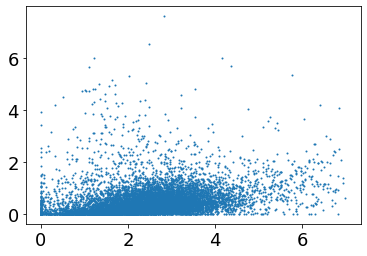

In [6]:
plt.scatter(table['ca2k'], table['ch'], s = 1)

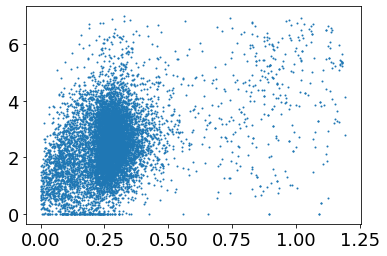

In [7]:
plt.scatter(table['g-r'], table['ca2k'] , s = 1)

In [8]:
kepler_da = np.array(['D' in ty for ty in table['ty']])
phot_class = (table['p_spec'] > 0.5) * (table['g'] < 17.5)

print(sum(kepler_da))
print(sum(phot_class))
sum(kepler_da*phot_class)

411
4891


0

# EMP Selection

In [9]:
emp = (
    (table['ca3'] < 1)*
    (table['ca2'] < 1)*
    (table['ca1'] < 1)*
    (table['ca2k'] > 0.75)*
    (table['ca2k'] < 1)*
    (table['g'] < 17.5)*
    (table['g-r_0'] >= 0.3)
)

print(len(table[emp]))

4


--------------------------------------------------
1276882477044162688
230.50863723865126 30.923945382405456
2.2580373
sdA/F
16.581
0.3309999999999995
0.919106662273407


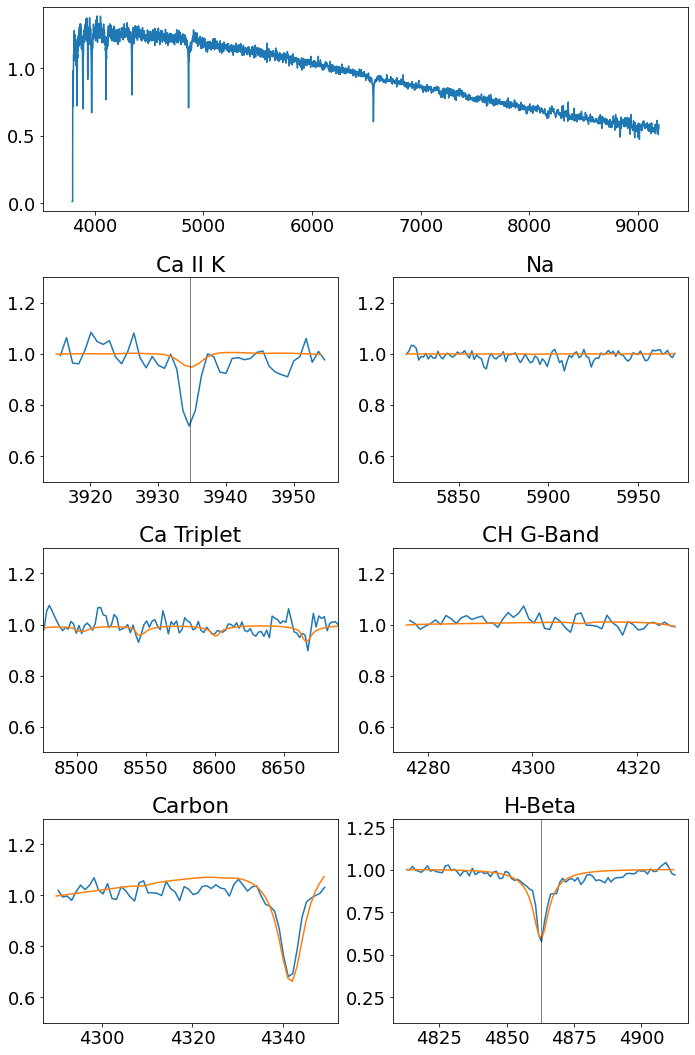

--------------------------------------------------
290930261314166528
25.15092436120991 23.74940873996049
18.643442
sdA/F
15.82
0.4720000000000013
0.9783530831336975


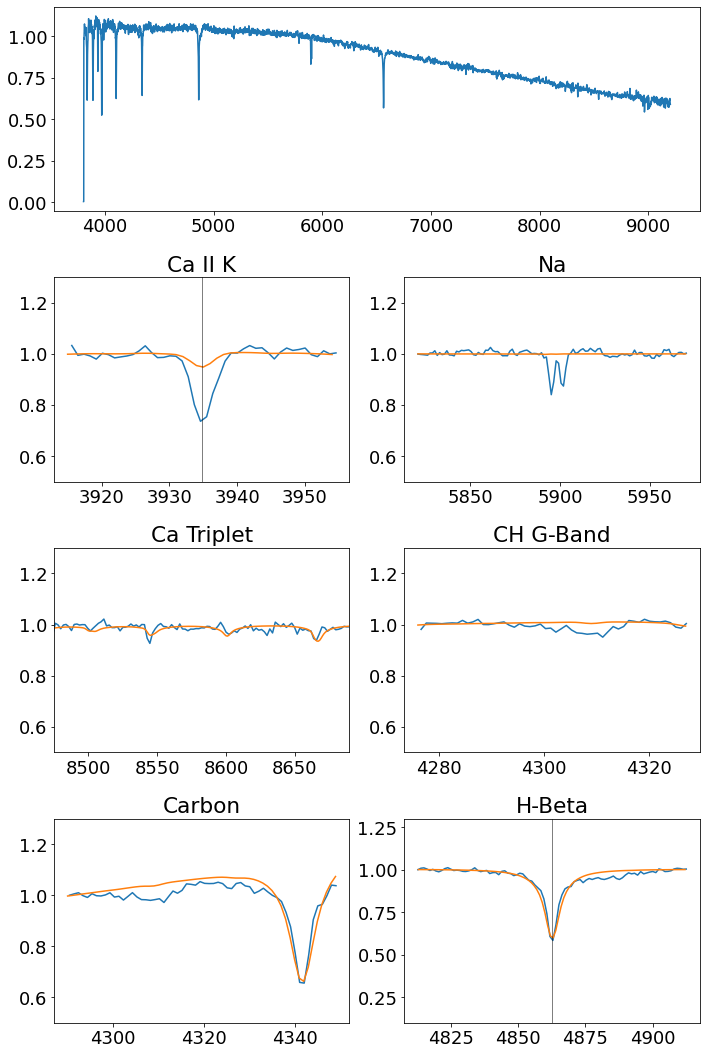

--------------------------------------------------
3976087728282022272
175.8475349868854 20.349428214381902
2.0013762
sdA/F
16.874000000000002
0.3060000000000045
0.9500961899757385


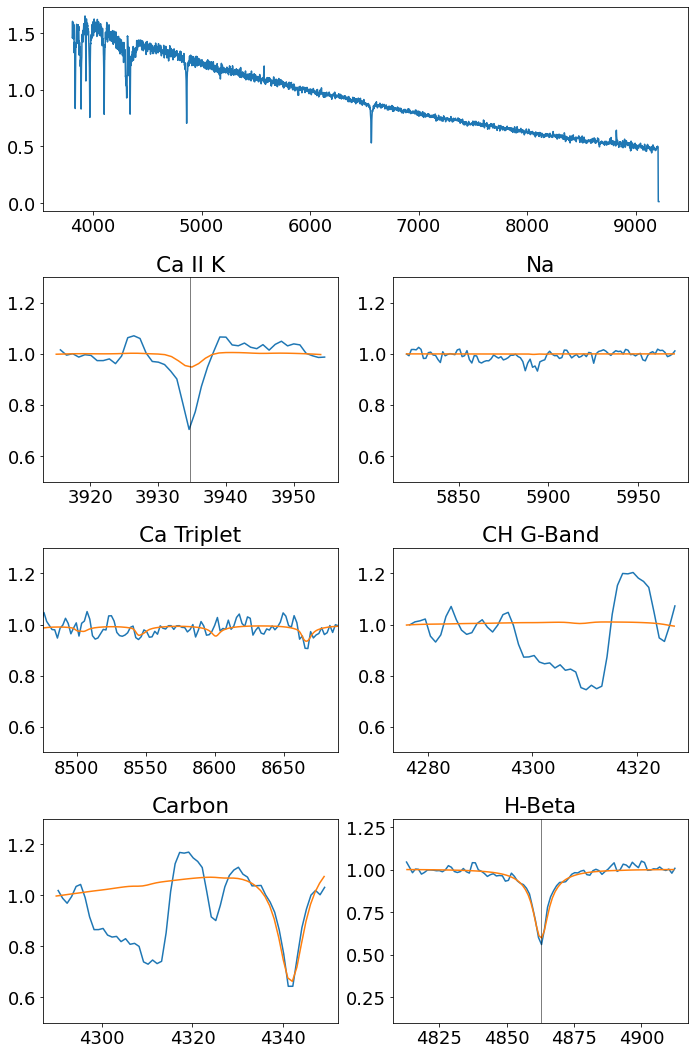

--------------------------------------------------
923068053360267136
119.6018029965604 43.61185363594758
10.329168
sdA
16.442999999999998
0.35399999999999565
0.8766430020332336


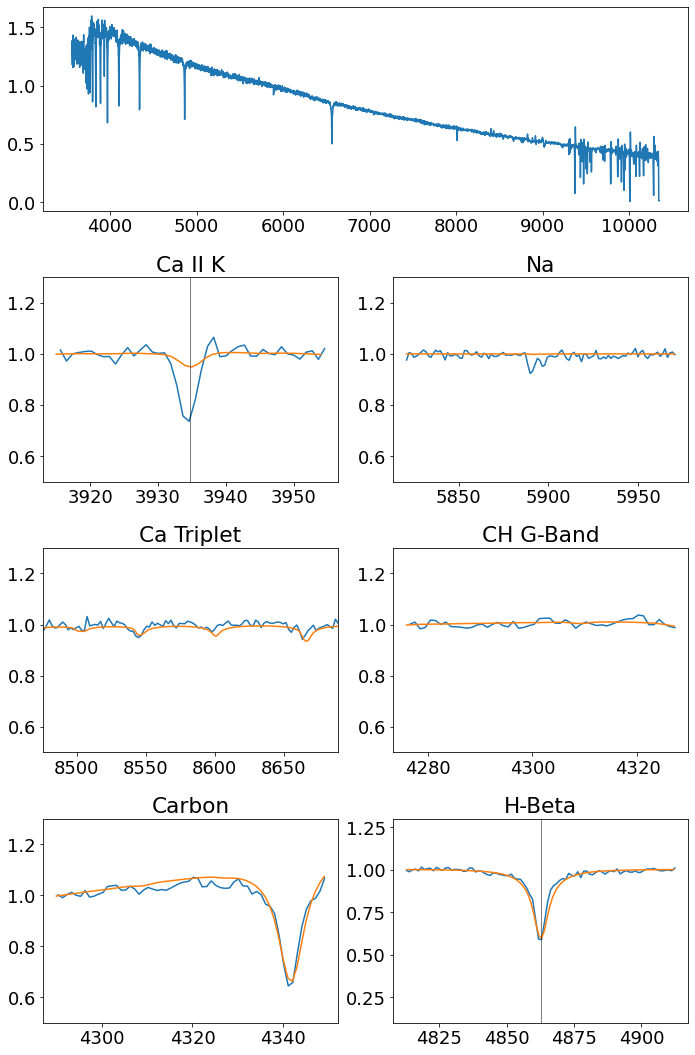

In [10]:
for obj in table[emp]:
    print('-'*50)
    print(obj['source_id'])
    print(obj['ra'], obj['dec'])
    print(obj['parallax_over_error'])
    print(obj['ty'])
    print(obj['g'])
    print(obj['g-r'])
    print(obj['ca2k'])
    
    wl, fl = get_spectrum(obj['source_id'])
    wl, fl = rv_corr(wl, fl)
    
    plot_metals(wl, fl, teff = 6500, logg = 4.5, alpha = 0)
    plt.show()

In [11]:
selection = [4450914642238765312,
2779812613335616384,
3927407606877041280,
1041117669033018112,
1543322422520153472,
926917477929764608,
2540804903154179840]

3927407606877041280
0.2579999999999991
0.9320024847984314


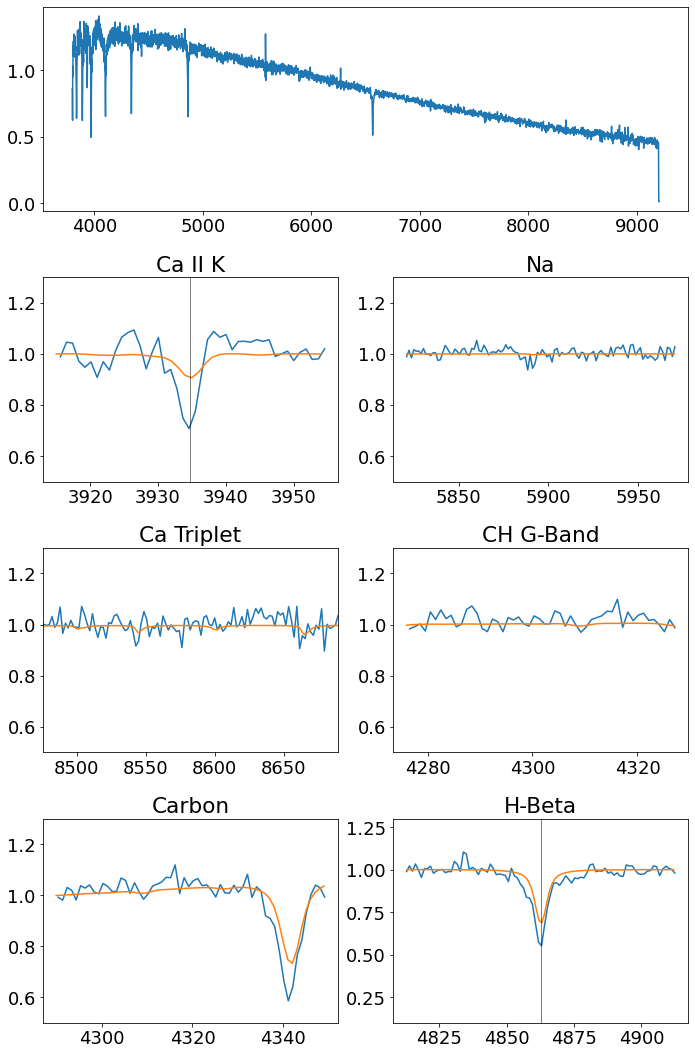

4450914642238765312
0.30100000000000016
1.1939635276794434


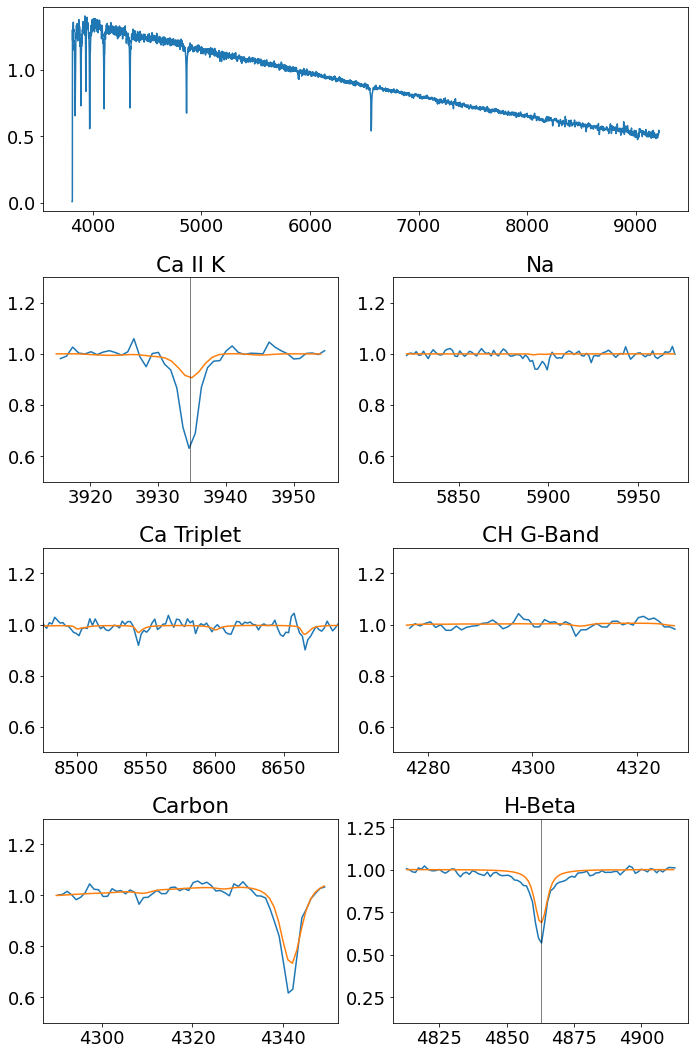

1041117669033018112
0.2740000000000009
0.8772194385528564


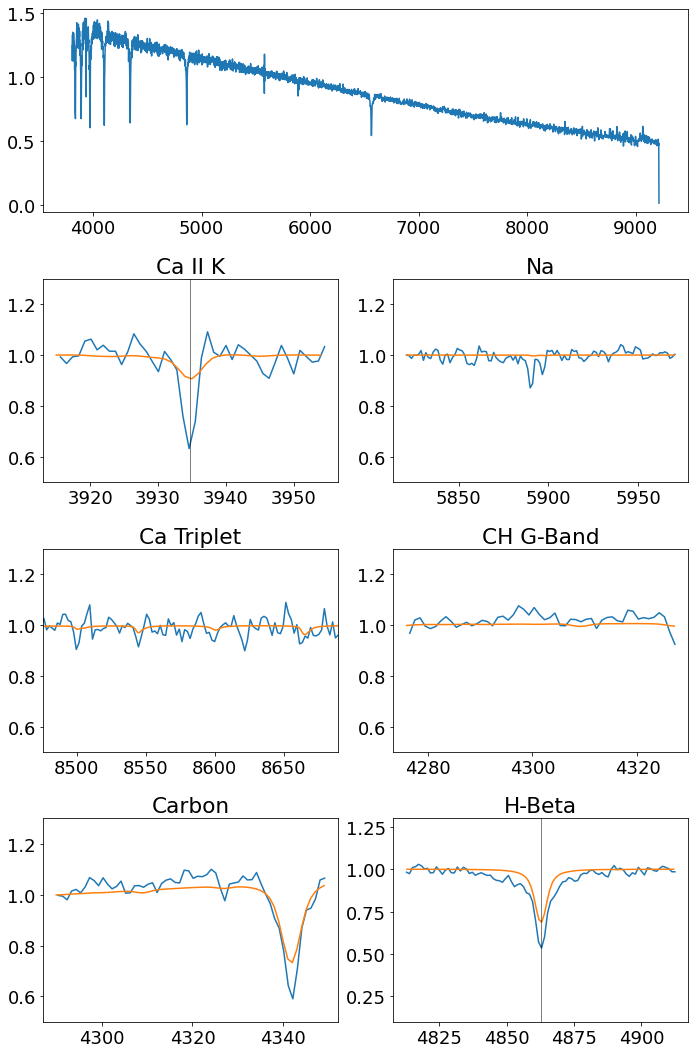

2779812613335616384
0.3130000000000006
1.112086534500122


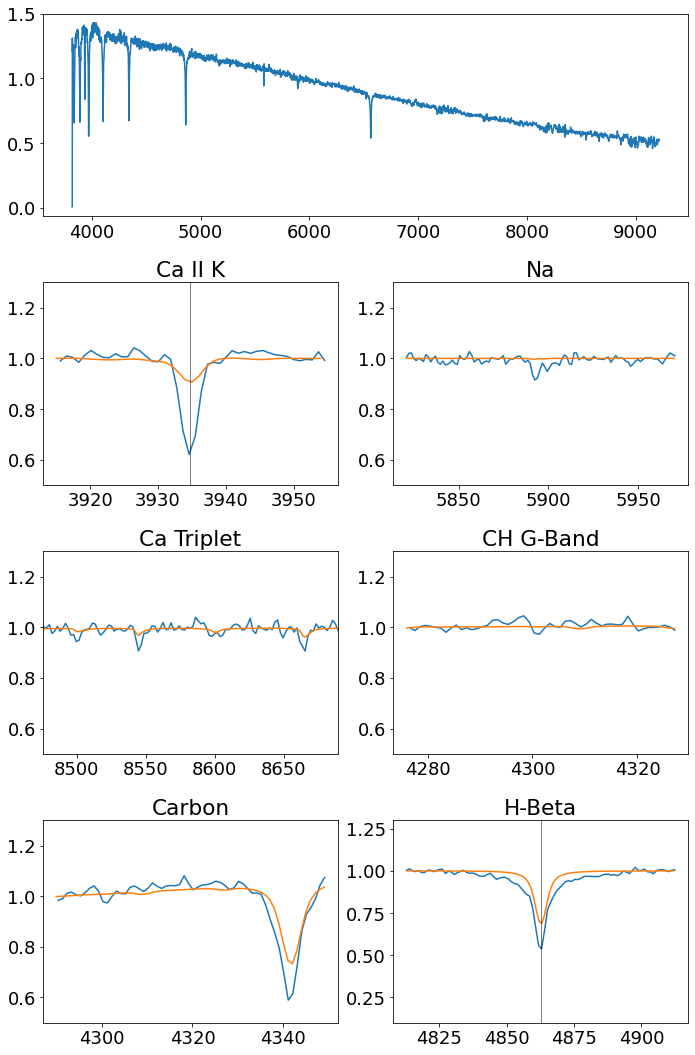

1543322422520153472
0.2749999999999986
0.9728060960769653


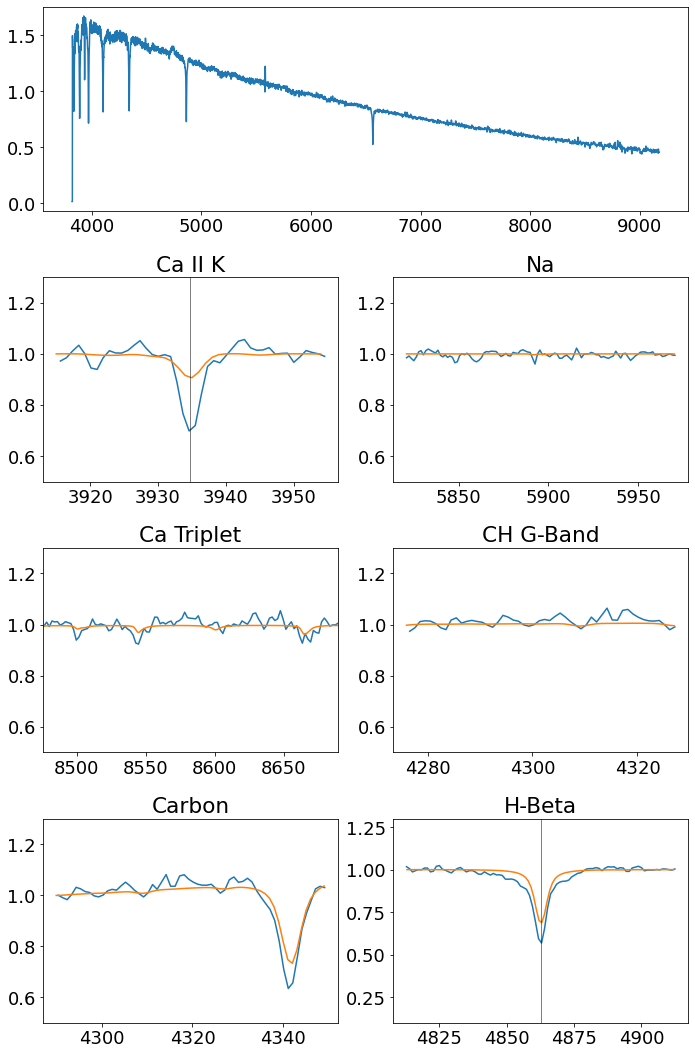

926917477929764608
0.28999999999999915
0.8688065409660339


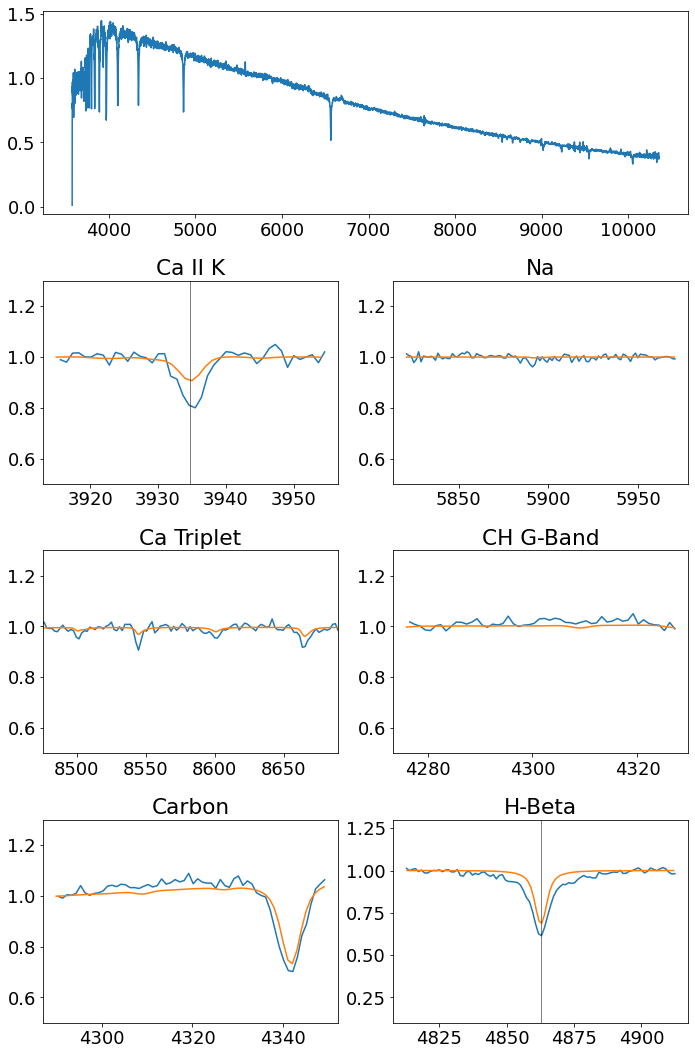

2540804903154179840
0.28000000000000114
0.9651800990104675


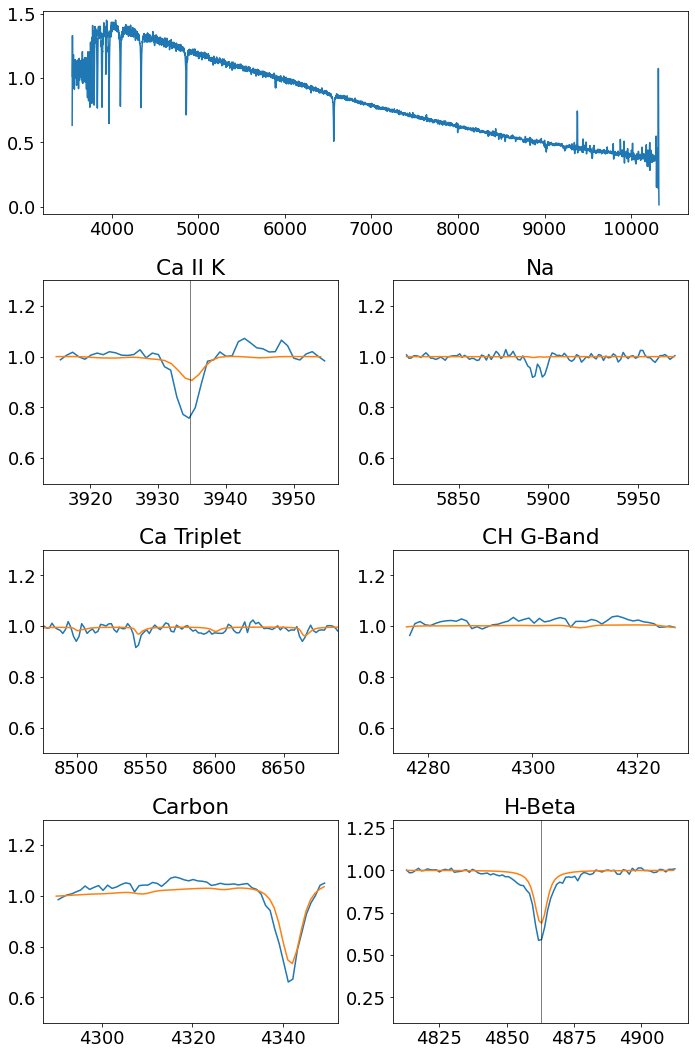

In [12]:
for src in table:
    if src['source_id'] in selection:
        wl, fl = get_spectrum(src['source_id'])
        print(src['source_id'])
        print(src['g-r'])
        print(src['ca2k'])
        wl, fl = rv_corr(wl, fl)
        
        plot_metals(wl, fl, teff = 6000, logg = 4.5)
        plt.show()